<a href="https://colab.research.google.com/github/david-siqi-liu/cs684-final-project/blob/master/cs684_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [0]:
### IMPORT DATA ###

# from urllib.request import urlretrieve
# import os
# from zipfile import ZipFile

# def download(url, file):
#     if not os.path.isfile(file):
#         urlretrieve(url,file)

# #If the downloaded file is a zip file than you can use below function to unzip it.
# def uncompress_features_labels(file):
#     if not os.path.isdir('data/' + file.split('.zip')[0]):
#         with ZipFile(file) as zipf:
#             zipf.extractall('data')
  
# for file in ['clipart.zip', 'infograph.zip', 'painting.zip', 'quickdraw.zip', 'real.zip', 'sketch.zip']:
#   download('http://csr.bu.edu/ftp/visda/2019/multi-source/' + file, file)
#   print("Downloaded: {0}".format(file))
#   uncompress_features_labels(file)
#   print("Extracted: {0}".format(file))

# for file in ['clipart', 'infograph', 'painting', 'quickdraw', 'real', 'sketch']:
#   download('http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/' + file + '_train.txt', 'label/' + file + '_train.txt')
#   download('http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/' + file + '_test.txt', 'label/' + file + '_test.txt')

# Install Packages

In [23]:
# PyTorch
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1MB 28kB/s 
     |████████████████████████████████| 8.8MB 49.5MB/s 
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Found existing installation: torchvision 0.4.2
    Uninstalling torchvision-0.4.2:
      Successfully uninstalled torchvision-0.4.2


# Import Packages

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Playground - CNN with MNIST

## Load Data

In [26]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

0it [00:00, ?it/s]

9920512it [00:01, 9168746.75it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 141860.75it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2307312.90it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 48170.72it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## EDA

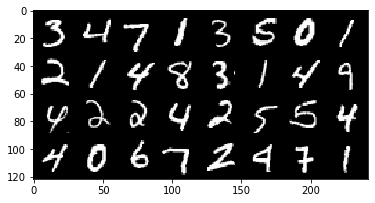

In [28]:
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [29]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## Model

In [0]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        # Grayscale so we only need one channel going in, hence in_channels=1
        # We use out_channels=32
        # Kernel size is 3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        # Dense layer, linear transformation of data
        # Output dimension = 128
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        # Input dimension = 128, 10 is the number of classes
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        # ReLu activation function
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        # SoftMax
        out = F.softmax(logits, dim=1)
        return out

In [32]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## Training

In [0]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [34]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.5975 | Train Accuracy: 86.25
Epoch: 1 | Loss: 1.4929 | Train Accuracy: 96.69
Epoch: 2 | Loss: 1.4821 | Train Accuracy: 97.78
Epoch: 3 | Loss: 1.4767 | Train Accuracy: 98.36
Epoch: 4 | Loss: 1.4737 | Train Accuracy: 98.68


## Test

In [35]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.12
